In [2]:
from datasets import load_dataset

ds = load_dataset("Bhuvaneshwari/intent_classification")

Repo card metadata block was not found. Setting CardData to empty.


train.csv:   0%|          | 0.00/818k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13808 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13808 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/13808 [00:00<?, ? examples/s]

In [3]:
!pip install cleantext

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from cleantext import clean
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import os
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, BatchNormalization, Dropout, ReLU
from keras.initializers import Constant
from keras.callbacks import EarlyStopping
sns.set()

2025-04-30 11:52:40.837550: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746013961.071587      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746013961.133954      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [110]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 13808
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 13808
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 13808
    })
})

In [6]:
df_train = pd.DataFrame({
    'text': ds['train']['text'],
    'intent': ds['train']['intent']
})

In [7]:
df_train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [8]:
df_train.shape

(13808, 2)

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13808 entries, 0 to 13807
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    13808 non-null  object
 1   intent  13808 non-null  object
dtypes: object(2)
memory usage: 215.9+ KB


In [10]:
df_train.apply(pd.isnull).sum()

text      0
intent    0
dtype: int64

In [7]:
df_train.duplicated().sum()

921

In [8]:
df_train.drop_duplicates(inplace = True)

In [12]:
df_train.shape

(12887, 2)

In [13]:
df_train['intent'].value_counts()

intent
GetWeather              1885
PlayMusic               1884
BookRestaurant          1876
SearchCreativeWork      1844
RateBook                1822
AddToPlaylist           1812
SearchScreeningEvent    1736
Book Meeting               8
Greetings                  7
Cancellation               5
Affirmation                4
excitment                  4
Name: count, dtype: int64

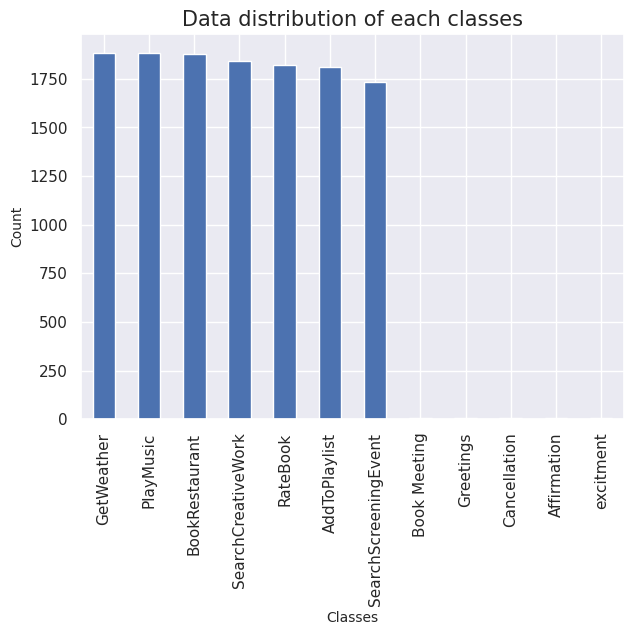

In [14]:
df_train['intent'].value_counts().plot(kind = 'bar', figsize = (7, 5))
plt.title('Data distribution of each classes', fontsize = 15)
plt.xlabel('Classes', fontsize = 10)
plt.ylabel('Count', fontsize = 10)
plt.show()

In [9]:
intent_list = []
for intent, intent_count in df_train['intent'].value_counts().items():
    if intent_count < 10:
        intent_list.append(intent)

In [10]:
print(intent_list)

['Book Meeting', 'Greetings', 'Cancellation', 'Affirmation', 'excitment']


In [11]:
for i in intent_list:
    df_train = df_train[df_train['intent'] != i]

In [18]:
df_train.shape

(12859, 2)

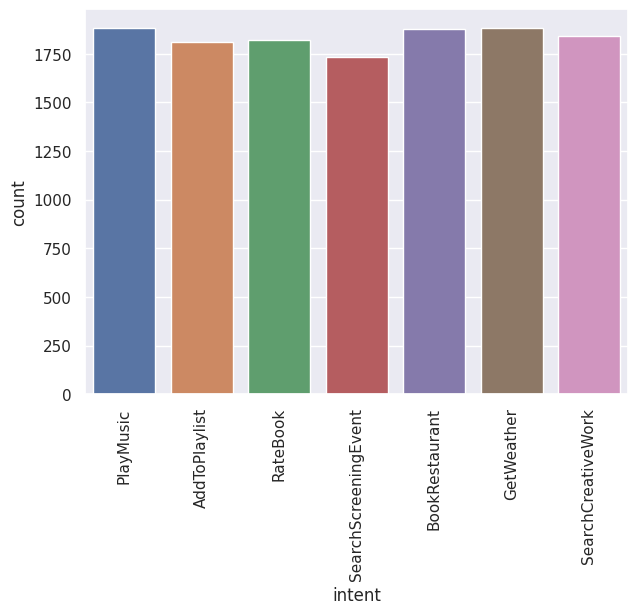

In [19]:
plt.figure(figsize = (7, 5))
sns.countplot(data = df_train, x = 'intent')
plt.xticks(rotation = 90)
plt.show()

In [16]:
df_test = pd.DataFrame({
    'text': ds['test']['text'],
    'intent': ds['test']['intent']
})

In [17]:
for i in intent_list:
    df_test = df_test[df_test['intent'] != i]

In [18]:
df_test.shape

(13084, 2)

In [19]:
df_test.duplicated().sum()

225

In [20]:
df_test.drop_duplicates(inplace = True)

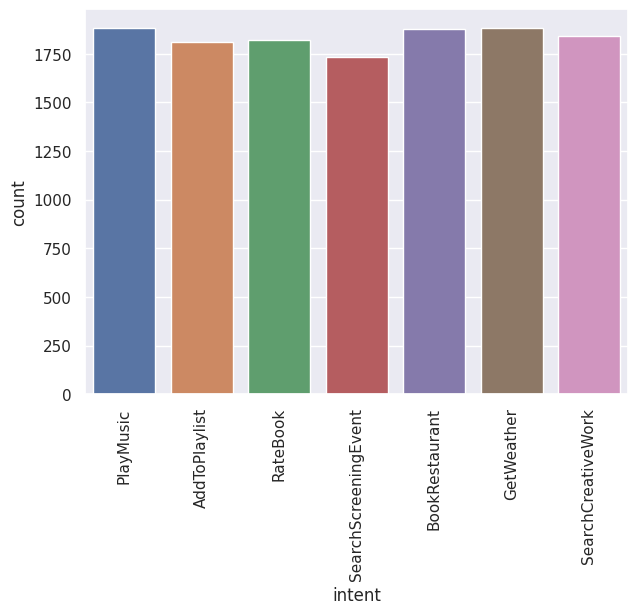

In [25]:
plt.figure(figsize = (7, 5))
sns.countplot(data = df_test, x = 'intent')
plt.xticks(rotation = 90)
plt.show()

In [21]:
df_valid = pd.DataFrame({
    'text': ds['validation']['text'],
    'intent': ds['validation']['intent']
})

In [22]:
for i in intent_list:
    df_valid = df_valid[df_valid['intent'] != i]

In [23]:
df_valid.duplicated().sum()

225

In [24]:
df_valid.drop_duplicates(inplace = True)

In [30]:
df_valid.shape

(12859, 2)

In [31]:
df_valid.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [32]:
df_test.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [33]:
df_train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


In [12]:
le = LabelEncoder()

In [13]:
df_train['label'] = le.fit_transform(df_train['intent'])

In [36]:
df_train.head()

,text,intent,label
0,listen to westbam alumb allergic on google music,PlayMusic,3
1,add step to me to the 50 clásicos playlist,AddToPlaylist,0
2,i give this current textbook a rating value of...,RateBook,4
3,play the song little robin redbreast,PlayMusic,3
4,please add iris dement to my playlist this is ...,AddToPlaylist,0


In [14]:
def text_cleaning(text):
    text1 = clean(text)
    text2 = re.sub('[^a-z]', ' ', text1)
    text3 = re.sub('\s+[a-z]\s+', ' ', text2)
    text4 = re.sub('\s+', ' ', text3)
    return text4

In [15]:
df_train['clean_text'] = df_train['text'].apply(text_cleaning)

In [39]:
df_train.head()

,text,intent,label,clean_text
0,listen to westbam alumb allergic on google music,PlayMusic,3,listen westbam alumb allerg googl music
1,add step to me to the 50 clásicos playlist,AddToPlaylist,0,add step cl sico playlist
2,i give this current textbook a rating value of...,RateBook,4,give current textbook rate valu best rate
3,play the song little robin redbreast,PlayMusic,3,play song littl robin redbreast
4,please add iris dement to my playlist this is ...,AddToPlaylist,0,pleas add iri dement playlist selena


In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['clean_text'])
seq = tokenizer.texts_to_sequences(df_train['clean_text'])

In [30]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

9689

In [31]:
maxlen = max([len(i) for i in seq])
print(maxlen)

22


In [32]:
pad_seq = pad_sequences(seq, maxlen = maxlen, padding = 'post')

In [33]:
y = df_train['label']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(pad_seq, y, test_size = 0.3, random_state = 101, stratify = y)

In [35]:
X_test2, X_valid, y_test2, y_valid = train_test_split(X_test, y_test, test_size = 0.1, random_state = 101, stratify = y_test)

In [47]:
print(f'Size of training set: {X_train.shape[0]}')
print(f'Size of test set: {X_test2.shape[0]}')
print(f'Size of validation set: {X_valid.shape[0]}')

Size of training set: 9001
Size of test set: 3472
Size of validation set: 386


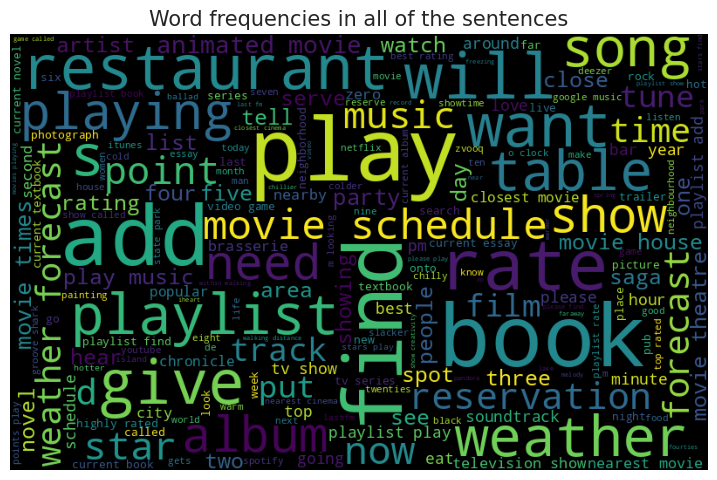

In [48]:
plt.figure(figsize = (9, 7))
all_sents = ' '.join([sentence for sentence in df_train['text']])
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sents)
plt.imshow(word_cloud)
plt.title('Word frequencies in all of the sentences', fontsize = 15)
plt.axis('off')
plt.show()

In [49]:
def word_cloud(data, intent):
    plt.figure(figsize = (9, 7))
    all_sents = ' '.join([sentence for sentence in df_train['text'][df_train['intent'] == intent]])
    wordcl = WordCloud(width = 800, height = 500, max_font_size = 100, random_state = 101).generate(all_sents)
    plt.imshow(wordcl)
    plt.title(intent, fontsize = 15)
    plt.axis('off')
    plt.show()

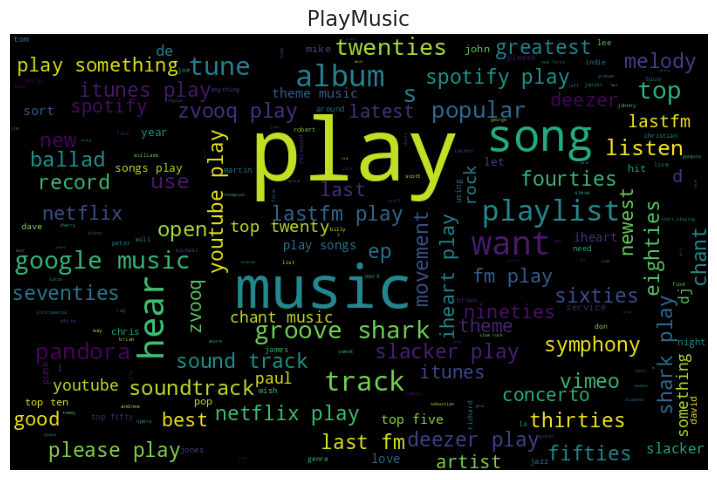

In [50]:
word_cloud(df_train, 'PlayMusic')

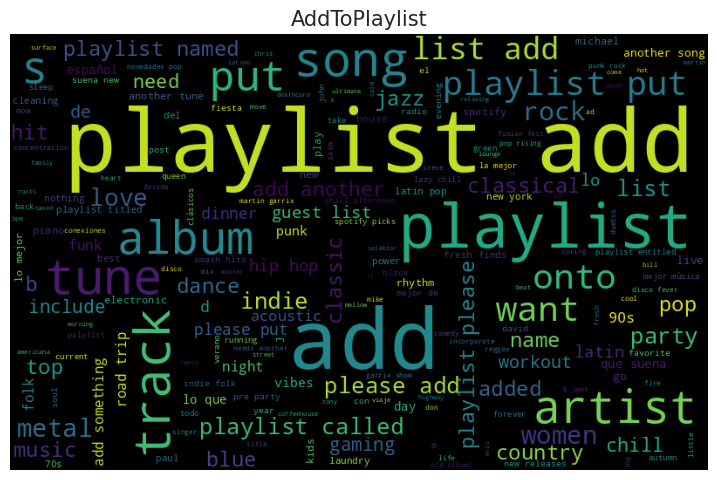

In [51]:
word_cloud(df_train, 'AddToPlaylist')

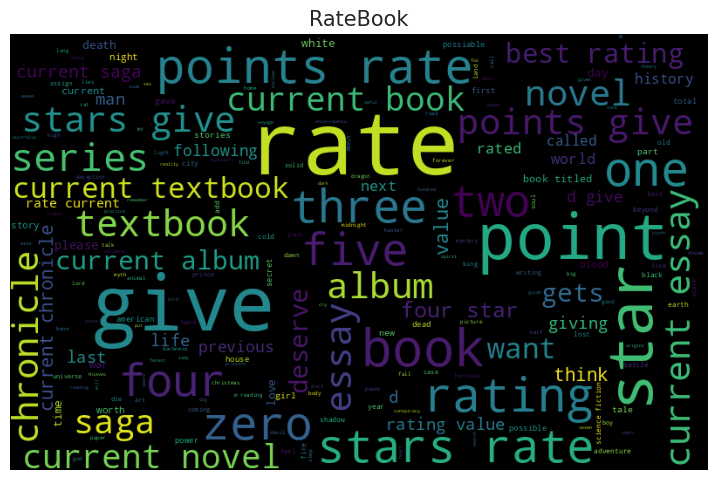

In [52]:
word_cloud(df_train, 'RateBook')

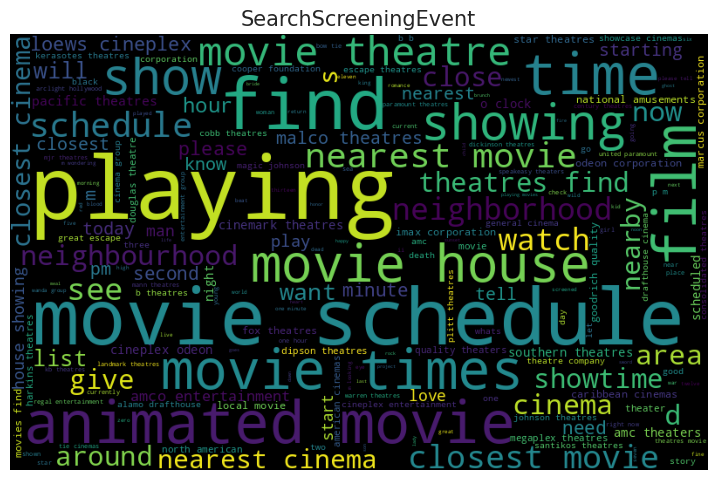

In [53]:
word_cloud(df_train, 'SearchScreeningEvent')

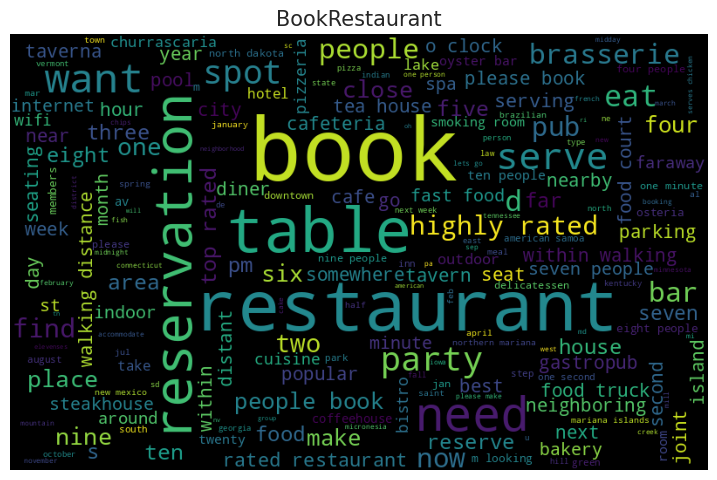

In [54]:
word_cloud(df_train, 'BookRestaurant')

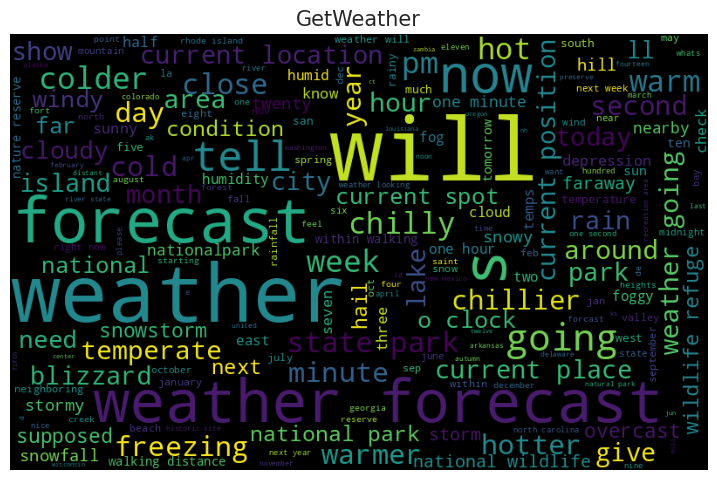

In [55]:
word_cloud(df_train, 'GetWeather')

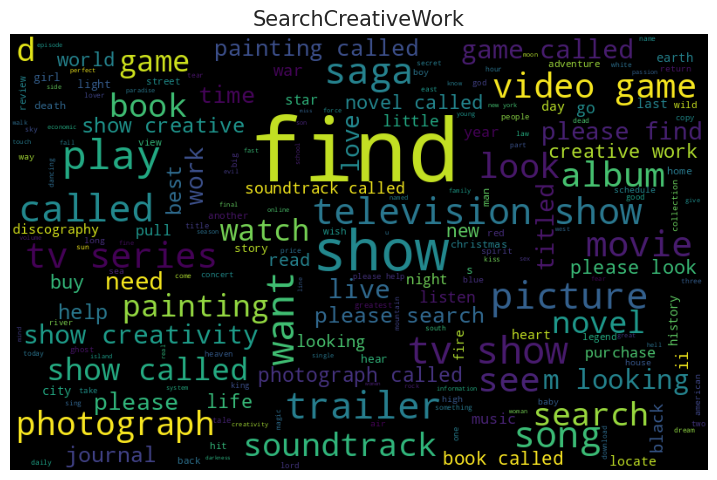

In [56]:
word_cloud(df_train, 'SearchCreativeWork')

In [36]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("danielwillgeorge/glove6b100dtxt")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/


In [37]:
os.listdir('/kaggle/input/')

['glove.6B.100d.txt']

In [38]:
embedding_matrix = dict()
glove_file = open('/kaggle/input/glove.6B.100d.txt')
for line in glove_file:
    record = line.split()
    word = record[0]
    vector = np.asarray(record[1:], dtype = 'float32')
    embedding_matrix[word] = vector
glove_file.close()

In [39]:
embedding_vectors = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vec = embedding_matrix.get(word)
    if vec is not None:
        embedding_vectors[index] = vec

In [40]:
embedding_vectors

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.24078   ,  0.024725  ,  0.64614999, ...,  0.010441  ,
         0.44889   ,  0.53435999],
       [-0.19744   ,  0.44830999,  0.13688999, ..., -0.56967998,
         0.0015374 ,  0.66600001],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.30388001,  0.048744  , -0.45769   , ...,  0.38166001,
         0.55572999,  0.19614001]])

In [63]:
model = Sequential()

In [64]:
model.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model.add(Bidirectional(LSTM(15)))
model.add(Dense(7, activation = 'softmax'))

I0000 00:00:1746001991.983986      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746001991.984695      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [65]:
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [66]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 2)

In [67]:
history = model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 100, callbacks = [early_stopping], batch_size = 64)

Epoch 1/100


I0000 00:00:1746001999.278148     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4928 - loss: 1.5844 - val_accuracy: 0.8290 - val_loss: 0.5940
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8698 - loss: 0.4880 - val_accuracy: 0.8860 - val_loss: 0.3418
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9090 - loss: 0.3143 - val_accuracy: 0.9197 - val_loss: 0.2595
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9352 - loss: 0.2274 - val_accuracy: 0.9249 - val_loss: 0.2183
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9373 - loss: 0.2003 - val_accuracy: 0.9197 - val_loss: 0.2127
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9459 - loss: 0.1756 - val_accuracy: 0.9326 - val_loss: 0.1933
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9592 - loss: 0.1387 - val_accuracy: 0.9326 - val_loss: 0.1974
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9605 - loss: 0.1335 - val_accuracy: 0.9430

In [63]:
def plot_results(train_accs, train_losses, valid_accs, valid_losses):
    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    xs = np.arange(1, len(train_accs) + 1, 1)
    axes[0].plot(xs, train_accs, label = 'Train')
    axes[0].plot(xs, valid_accs, label = 'Validation')
    axes[0].set_title('Accuracy', fontsize = 15)
    axes[0].set_xlabel('Epoch', fontsize = 10)
    axes[0].set_ylabel('Accuracy', fontsize = 10)
    axes[0].set_xticks(xs)
    axes[1].plot(xs, train_losses, label = 'Train')
    axes[1].plot(xs, valid_losses, label = 'Validation')
    axes[1].set_title('Loss', fontsize = 15)
    axes[1].set_xlabel('Epoch', fontsize = 10)
    axes[1].set_ylabel('Loss', fontsize = 10)
    axes[1].set_xticks(xs)
    plt.tight_layout()
    axes[0].legend()
    axes[1].legend()
    plt.show()

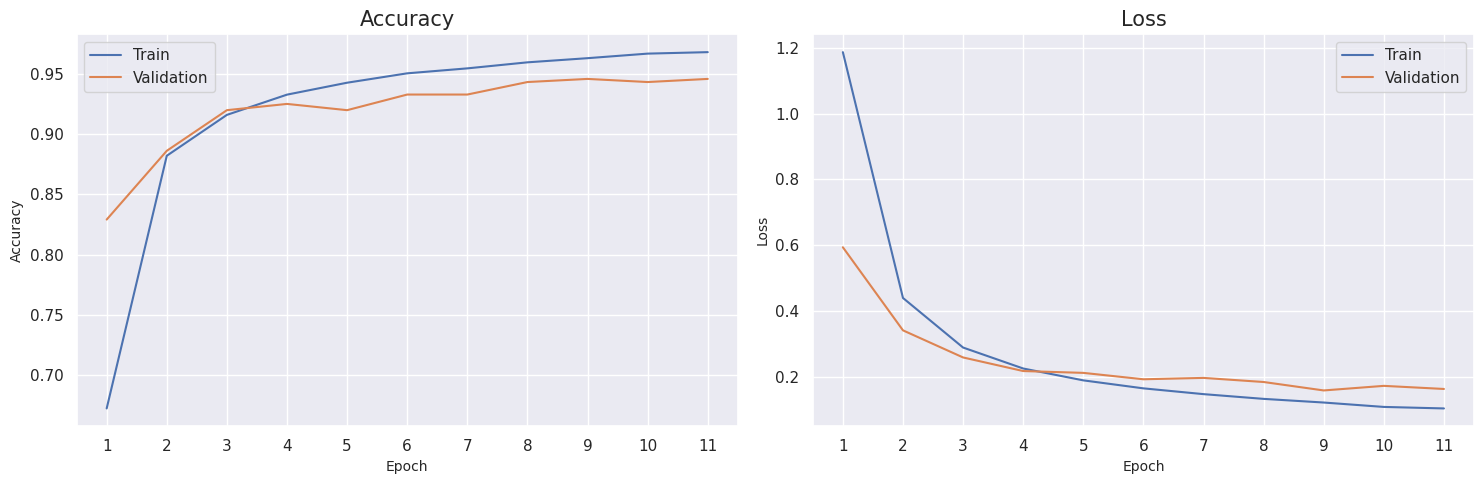

In [69]:
plot_results(history.history['accuracy'], history.history['loss'], history.history['val_accuracy'], history.history['val_loss'])

In [70]:
model2 = Sequential()

In [71]:
model2.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model2.add(Bidirectional(LSTM(15)))
model2.add(BatchNormalization())
model2.add(Dense(7, activation = 'softmax'))

In [72]:
model2.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [73]:
early_stopping2 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [74]:
history2 = model2.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 100, callbacks = [early_stopping2], batch_size = 64)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.5747 - loss: 1.2442 - val_accuracy: 0.8627 - val_loss: 1.0734
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9050 - loss: 0.3117 - val_accuracy: 0.9171 - val_loss: 0.4180
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9297 - loss: 0.2169 - val_accuracy: 0.9352 - val_loss: 0.2466
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9472 - loss: 0.1647 - val_accuracy: 0.9378 - val_loss: 0.1982
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9558 - loss: 0.1395 - val_accuracy: 0.9430 - val_loss: 0.1777
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9620 - loss: 0.1186 - val_accuracy: 0.9301 - val_loss: 0.1962
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9664 - loss: 0.1064 - val_accuracy: 0.9275 - val_loss: 0.1921


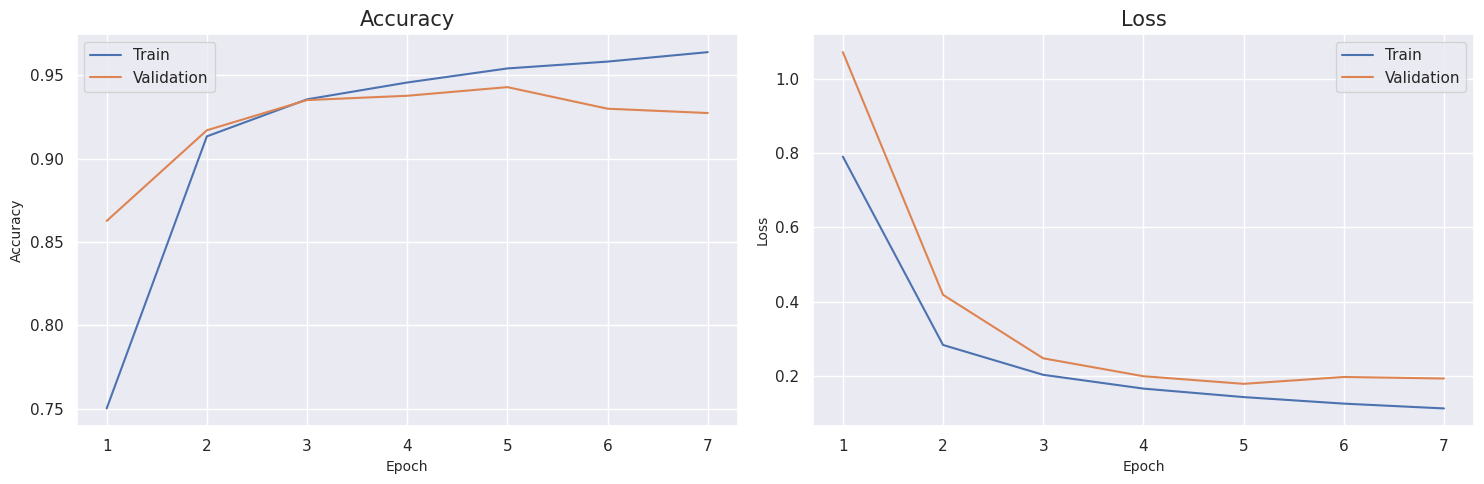

In [75]:
plot_results(history2.history['accuracy'], history2.history['loss'], history2.history['val_accuracy'], history2.history['val_loss'])

In [76]:
model3 = Sequential()

In [77]:
model3.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model3.add(Bidirectional(LSTM(15)))
model3.add(Dropout(0.25))
model3.add(Dense(7, activation = 'softmax'))

In [78]:
model3.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [79]:
early_stopping3 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [80]:
history3 = model3.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 100, callbacks = [early_stopping3], batch_size = 64)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.4984 - loss: 1.5572 - val_accuracy: 0.8264 - val_loss: 0.6640
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8454 - loss: 0.5940 - val_accuracy: 0.8964 - val_loss: 0.3706
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8946 - loss: 0.3831 - val_accuracy: 0.9041 - val_loss: 0.2960
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9198 - loss: 0.2903 - val_accuracy: 0.9171 - val_loss: 0.2448
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9353 - loss: 0.2385 - val_accuracy: 0.9249 - val_loss: 0.2138
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9390 - loss: 0.2048 - val_accuracy: 0.9404 - val_loss: 0.1925
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9463 - loss: 0.1907 - val_accuracy: 0.9352 - val_loss: 0.1936
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9484 - loss: 0.1757 - val_accu

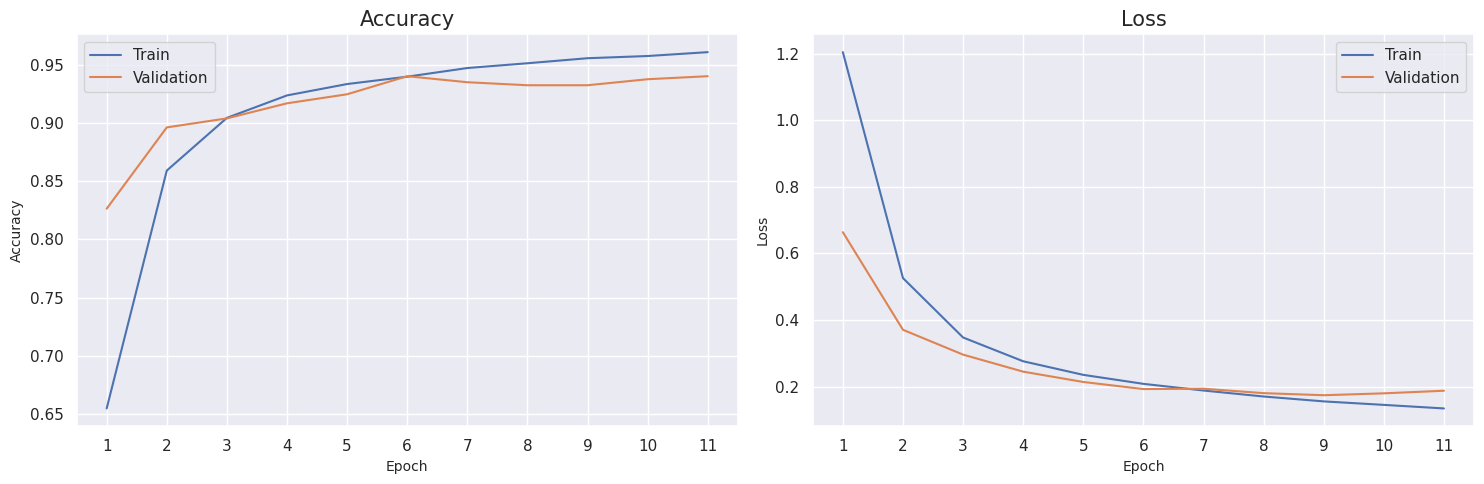

In [81]:
plot_results(history3.history['accuracy'], history3.history['loss'], history3.history['val_accuracy'], history3.history['val_loss'])

In [82]:
model4 = Sequential()

In [83]:
model4.add(Embedding(vocab_size, 100, embeddings_initializer = Constant(embedding_vectors), trainable = False))
model4.add(Bidirectional(LSTM(15)))
model4.add(BatchNormalization())
model4.add(Dropout(0.25))
model4.add(Dense(7, activation = 'softmax'))

In [84]:
model4.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [85]:
early_stopping4 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [86]:
history4 = model4.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs = 100, callbacks = [early_stopping4], batch_size = 64)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5473 - loss: 1.2631 - val_accuracy: 0.8575 - val_loss: 1.0440
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8876 - loss: 0.3798 - val_accuracy: 0.9119 - val_loss: 0.4571
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9159 - loss: 0.2656 - val_accuracy: 0.9275 - val_loss: 0.2445
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9309 - loss: 0.2115 - val_accuracy: 0.9145 - val_loss: 0.1968
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9420 - loss: 0.1879 - val_accuracy: 0.9378 - val_loss: 0.1789
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9507 - loss: 0.1600 - val_accuracy: 0.9352 - val_loss: 0.1644
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9549 - loss: 0.1423 - val_accuracy: 0.9430 - val_loss: 0.1501
Epoch 8/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9565 - loss: 0.1299 - val_accu

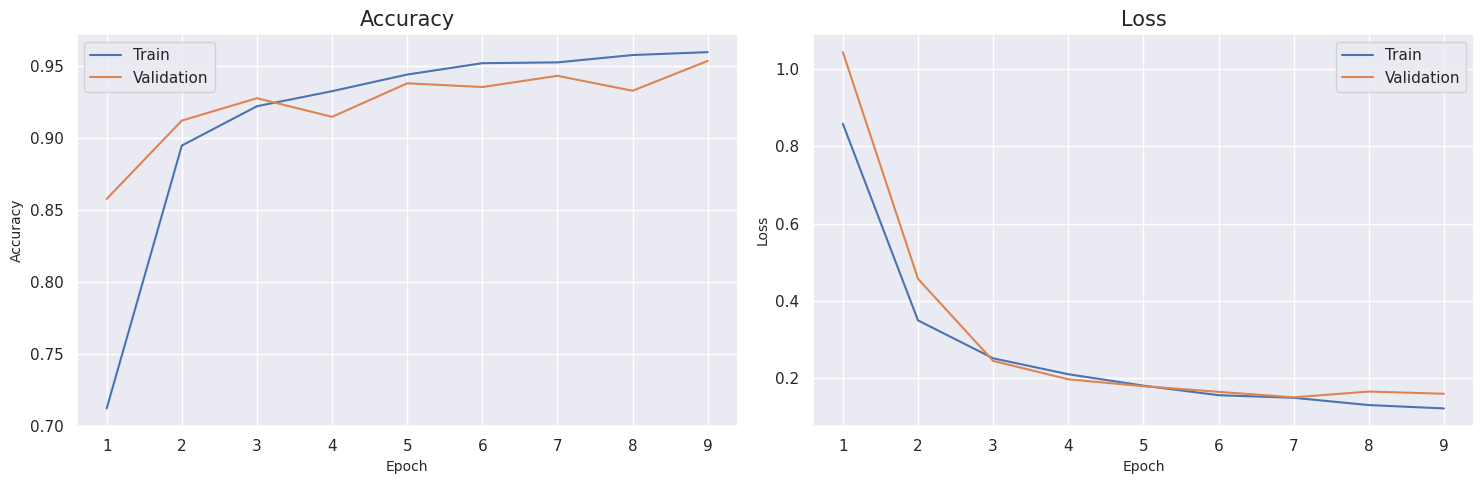

In [87]:
plot_results(history4.history['accuracy'], history4.history['loss'], history4.history['val_accuracy'], history4.history['val_loss'])

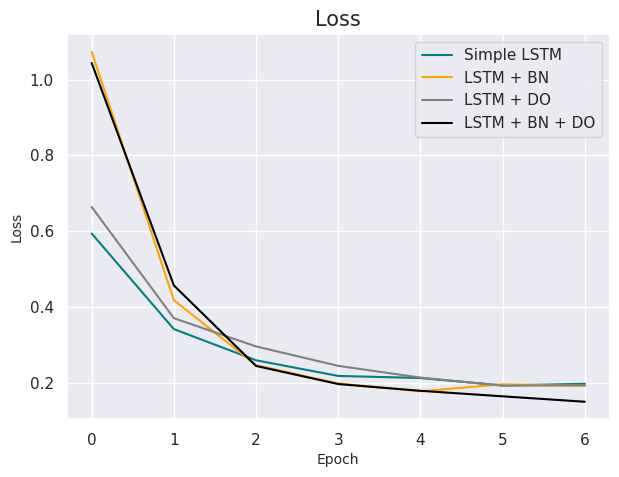

In [88]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['val_loss'][:7], label = 'Simple LSTM', color = 'teal')
plt.plot(history2.history['val_loss'][:7], label = 'LSTM + BN', color = 'orange')
plt.plot(history3.history['val_loss'][:7], label = 'LSTM + DO', color = 'gray')
plt.plot(history4.history['val_loss'][:7], label = 'LSTM + BN + DO', color = 'black')
plt.title('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

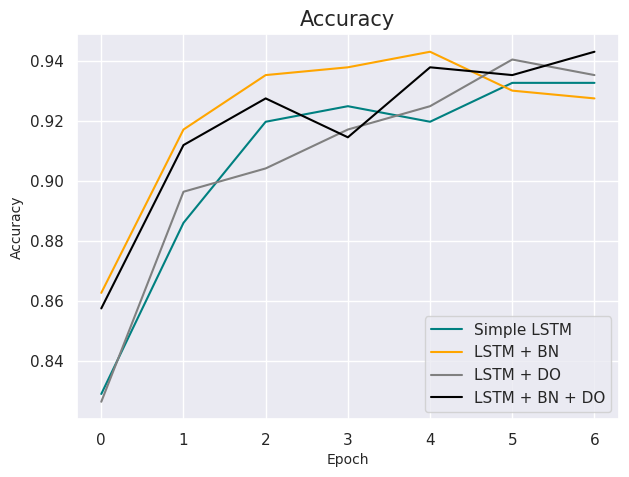

In [90]:
plt.figure(figsize = (7, 5))
plt.plot(history.history['val_accuracy'][:7], label = 'Simple LSTM', color = 'teal')
plt.plot(history2.history['val_accuracy'][:7], label = 'LSTM + BN', color = 'orange')
plt.plot(history3.history['val_accuracy'][:7], label = 'LSTM + DO', color = 'gray')
plt.plot(history4.history['val_accuracy'][:7], label = 'LSTM + BN + DO', color = 'black')
plt.title('Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

In [78]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from tqdm import trange
import torch.optim as optim
import math

In [79]:
class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype = torch.float32)
        self.labels = torch.tensor(labels, dtype = torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [81]:
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test2, y_test2)
valid_dataset = MyDataset(X_valid, y_valid)

ValueError: could not determine the shape of object type 'Series'

In [44]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False)
valid_loader = DataLoader(valid_dataset, batch_size = 64, shuffle = False)

In [99]:
device = ('cuda' if torch.cuda.is_available()
         else 'mps' if torch.backends.mps.is_available()
         else 'cpu')
print(f'Using {device} device')

Using cuda device


In [65]:
def train_step(model, criterion, optimizer, dataloader, device = device):
    running_loss, correct = 0, 0
    model.train()
    optimizer.zero_grad()
    for x, y in dataloader:
        x, y = x.to(device).long(), y.to(device).long()
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

In [66]:
def valid_step(model, criterion, dataloader, device = device):
    running_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device).long(), y.to(device).long()
            pred = model(x)
            running_loss += criterion(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return running_loss / len(dataloader), 100 * correct / len(dataloader.dataset)

In [67]:
def train_model(model, n_epochs, optimizer, train_loader, valid_loader, device = device):
    criterion = nn.CrossEntropyLoss()
    early_stopping = EarlyStopping(patience = 20, delta = 0)
    train_accs, train_losses = [], []
    valid_accs, valid_losses = [], []
    for epoch in (pbar := trange(n_epochs)):
        train_loss, train_acc = train_step(model, criterion, optimizer, train_loader, device)
        valid_loss, valid_acc = valid_step(model, criterion, valid_loader, device)
        pbar.set_description(f'Train Loss: {train_loss:.3f} | Valid Loss: {valid_loss:.3f} | Train Acc: {train_acc:.2f} | Valid Acc: {valid_acc:.2f}')
        train_accs.append(train_acc)
        train_losses.append(train_loss)
        valid_accs.append(valid_acc)
        valid_losses.append(valid_loss)
        early_stopping(valid_loss, model)
    plot_results(train_accs, train_losses, valid_accs, valid_losses)
    return {'train_loss': train_losses, 'train_acc': train_accs, 'valid_loss': valid_losses, 'valid_acc': valid_accs}

In [70]:
class lstm_model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, embedding_vectors, hidden_units, num_classes):
        super(lstm_model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight.data.copy_(torch.tensor(embedding_vectors, dtype = torch.float32))
        self.lstm = nn.LSTM(embedding_dim, hidden_units, batch_first = True, bidirectional = True)
        self.batch_norm = nn.BatchNorm1d(hidden_units * 2)
        self.dropout = nn.Dropout(0.25)
        self.fc = nn.Linear(hidden_units * 2, num_classes)

        self.network = nn.Sequential(
            self.embedding,
            self.lstm,
            self.fc
        )

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

Train Loss: 0.051 | Valid Loss: 0.347 | Train Acc: 98.86 | Valid Acc: 93.52: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


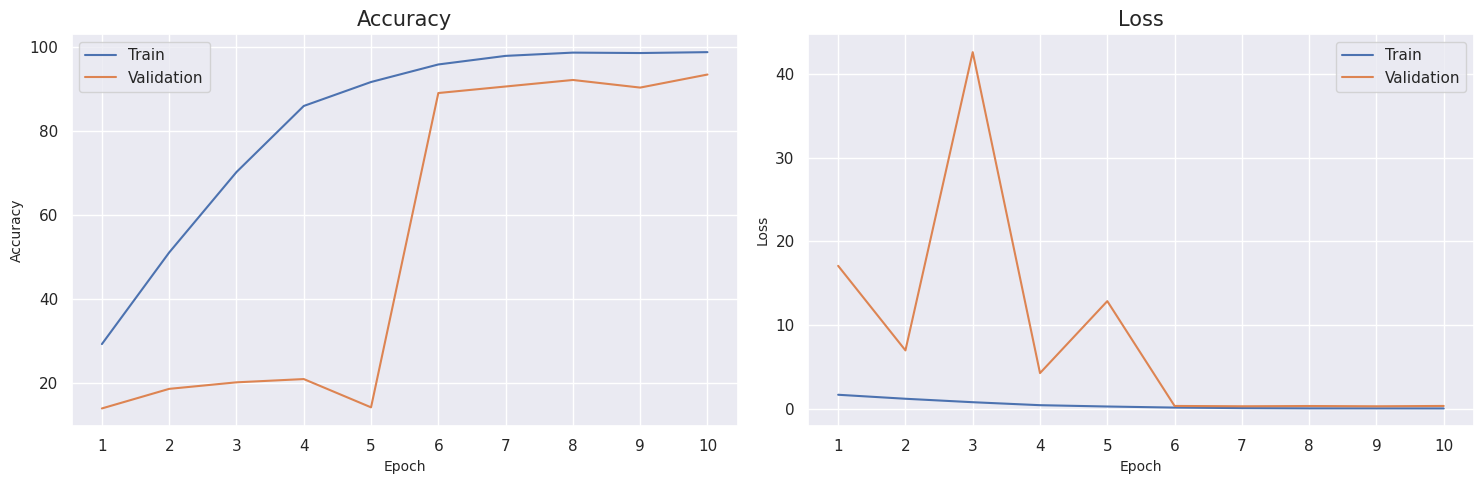

In [75]:
model = lstm_model(vocab_size = vocab_size, embedding_dim = 100, embedding_vectors = embedding_vectors, hidden_units = 15, num_classes = 7).to(device)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
results = train_model(model, 10, optimizer, train_loader, valid_loader)

In [16]:
import tensorflow as tf
import keras_nlp
import keras_hub

In [17]:
df_train.head()

,text,intent,label,clean_text
0,listen to westbam alumb allergic on google music,PlayMusic,3,listen westbam alumb allerg googl music
1,add step to me to the 50 clásicos playlist,AddToPlaylist,0,add step cl sico playlist
2,i give this current textbook a rating value of...,RateBook,4,give current textbook rate valu best rate
3,play the song little robin redbreast,PlayMusic,3,play song littl robin redbreast
4,please add iris dement to my playlist this is ...,AddToPlaylist,0,pleas add iri dement playlist selena


In [18]:
X = df_train['clean_text']
y = df_train['label']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 101, stratify = y)

In [20]:
X_test2, X_valid, y_test2, y_valid = train_test_split(X_test, y_test, test_size = 0.1, random_state = 101, stratify = y_test)

In [41]:
def data_preparation(X, y):
    X_ragged = tf.ragged.constant(X)
    X_tensor = tf.convert_to_tensor(X_ragged)
    data = tf.data.Dataset.from_tensor_slices((X_tensor, y.values))
    return data

In [42]:
train_data = data_preparation(X_train, y_train)

In [43]:
test_data = data_preparation(X_test2, y_test2)

In [44]:
valid_data = data_preparation(X_valid, y_valid)

In [45]:
train_dataset = train_data.cache().shuffle(len(X_train)).batch(8).prefetch(tf.data.AUTOTUNE)
test_dataset = test_data.cache().shuffle(len(X_test2)).batch(8).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_data.cache().shuffle(len(X_valid)).batch(8).prefetch(tf.data.AUTOTUNE)

In [52]:
tokenizer2 = keras_nlp.models.BertTokenizer.from_preset('bert_small_en_uncased')

In [58]:
preprocessor = keras_nlp.models.BertPreprocessor(tokenizer2, sequence_length = 512, truncate = 'round_robin')

In [59]:
bert_small = keras_nlp.models.BertClassifier.from_preset(
    'bert_small_en_uncased',
    preprocessor = preprocessor,
    num_classes = 7
)

In [60]:
bert_small.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [61]:
early_stopping7 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [62]:
history7 = bert_small.fit(train_dataset, validation_data = valid_dataset, epochs = 100, callbacks = [early_stopping7])

Epoch 1/100


I0000 00:00:1746014922.269590     112 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1746014934.079623     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1126/1126 ━━━━━━━━━━━━━━━━━━━━ 203s 152ms/step - accuracy: 0.7292 - loss: 1.0896 - val_accuracy: 0.9585 - val_loss: 0.1577
Epoch 2/100
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 156s 138ms/step - accuracy: 0.9703 - loss: 0.1354 - val_accuracy: 0.9689 - val_loss: 0.1252
Epoch 3/100
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 155s 138ms/step - accuracy: 0.9805 - loss: 0.0831 - val_accuracy: 0.9689 - val_loss: 0.0891
Epoch 4/100
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 155s 138ms/step - accuracy: 0.9884 - loss: 0.0469 - val_accuracy: 0.9741 - val_loss: 0.0722
Epoch 5/100
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 156s 139ms/step - accuracy: 0.9908 - loss: 0.0359 - val_accuracy: 0.9741 - val_loss: 0.0882
Epoch 6/100
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 156s 138ms/step - accuracy: 0.9922 - loss: 0.0261 - val_accuracy: 0.9767 - val_loss: 0.0876


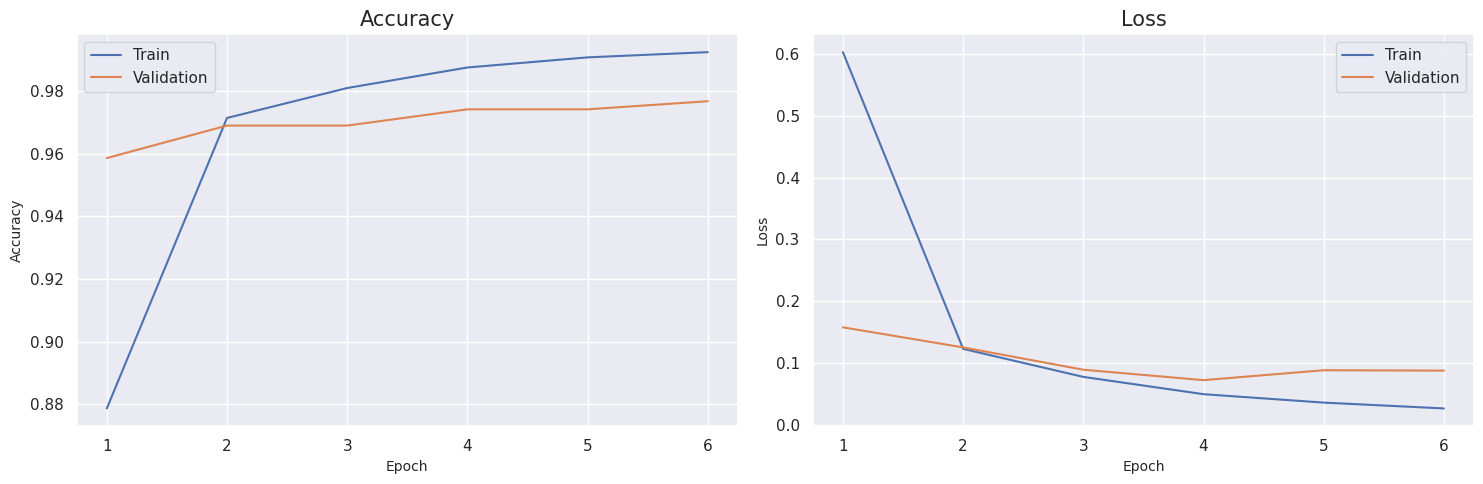

In [65]:
plot_results(history7.history['accuracy'], history7.history['loss'], history7.history['val_accuracy'], history7.history['val_loss'])

In [66]:
tokenizer3 = keras_nlp.models.DistilBertTokenizer.from_preset('distil_bert_base_en_uncased')

In [67]:
preprocessor2 = keras_nlp.models.DistilBertPreprocessor(tokenizer3, sequence_length = 512, truncate = 'round_robin')

In [70]:
distil_bert = keras_nlp.models.DistilBertClassifier.from_preset(
    'distil_bert_base_en_uncased',
    preprocessor = preprocessor2,
    num_classes = 7
)

In [71]:
distil_bert.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
    metrics = ['accuracy']
)

In [72]:
early_stopping8 = EarlyStopping(monitor = 'val_loss', patience = 2)

In [73]:
history8 = distil_bert.fit(train_dataset, validation_data = valid_dataset, epochs = 100, callbacks = [early_stopping8])

Epoch 1/100
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 527s 429ms/step - accuracy: 0.7592 - loss: 0.9365 - val_accuracy: 0.9689 - val_loss: 0.1245
Epoch 2/100
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 463s 411ms/step - accuracy: 0.9760 - loss: 0.0940 - val_accuracy: 0.9715 - val_loss: 0.1085
Epoch 3/100
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 463s 411ms/step - accuracy: 0.9871 - loss: 0.0478 - val_accuracy: 0.9845 - val_loss: 0.0612
Epoch 4/100
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 463s 411ms/step - accuracy: 0.9919 - loss: 0.0328 - val_accuracy: 0.9767 - val_loss: 0.0690
Epoch 5/100
1126/1126 ━━━━━━━━━━━━━━━━━━━━ 463s 411ms/step - accuracy: 0.9934 - loss: 0.0218 - val_accuracy: 0.9793 - val_loss: 0.0748


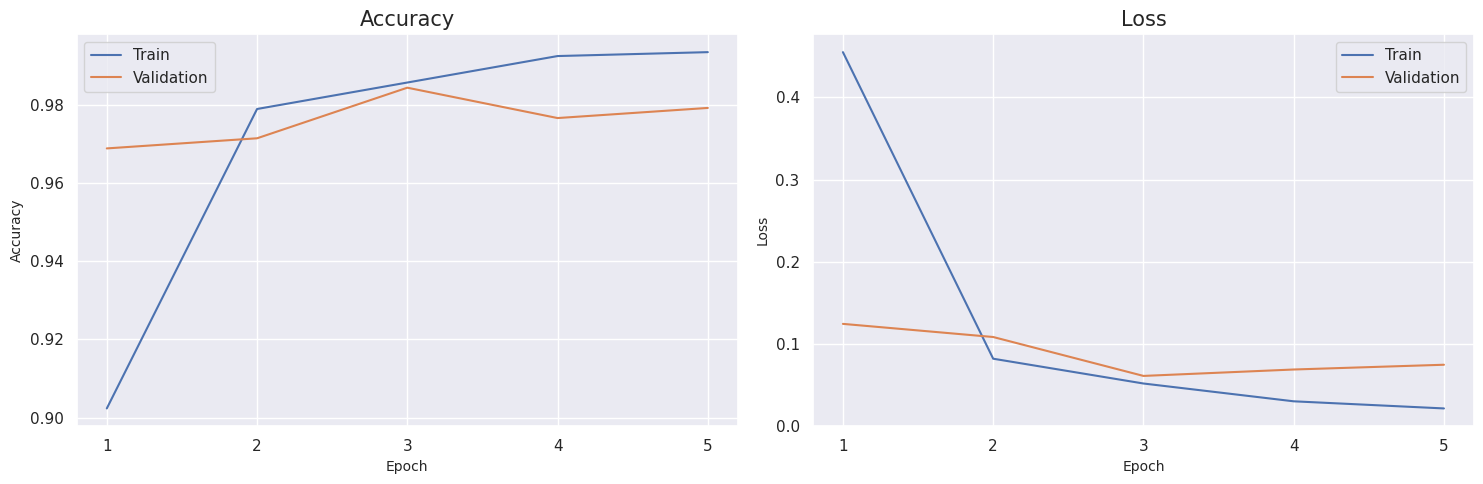

In [74]:
plot_results(history8.history['accuracy'], history8.history['loss'], history8.history['val_accuracy'], history8.history['val_loss'])

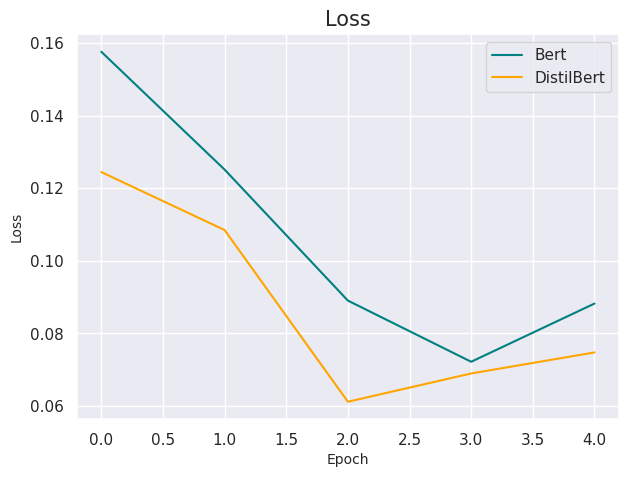

In [76]:
plt.figure(figsize = (7, 5))
plt.plot(history7.history['val_loss'][:5], label = 'Bert', color = 'teal')
plt.plot(history8.history['val_loss'][:5], label = 'DistilBert', color = 'orange')
plt.title('Loss', fontsize = 15)
plt.xlabel('Epoch', fontsize = 10)
plt.ylabel('Loss', fontsize = 10)
plt.legend()
plt.show()

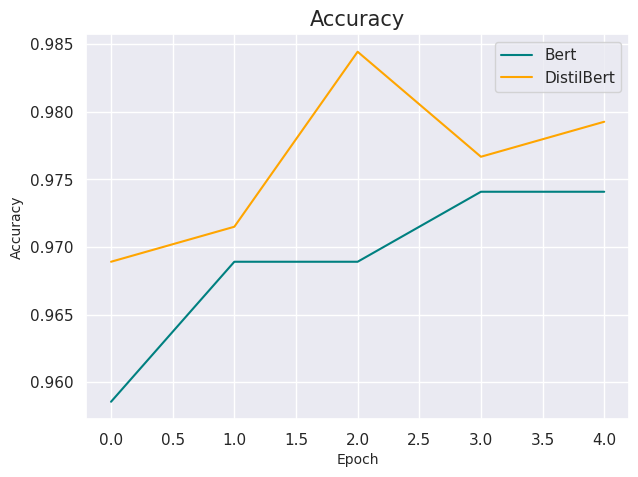

In [77]:
plt.figure(figsize = (7, 5))
plt.plot(history7.history['val_accuracy'][:5], label = 'Bert', color = 'teal')
plt.plot(history8.history['val_accuracy'][:5], label = 'DistilBert', color = 'orange')
plt.title('Accuracy', fontsize = 15)
plt.xlabel('Epoch', fontsize = 10)
plt.ylabel('Accuracy', fontsize = 10)
plt.legend()
plt.show()

In [82]:
from transformers import BertTokenizer, BertForSequenceClassification

In [86]:
tokenizer4 = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [118]:
class CustomDataset(Dataset):
    def __init__(self, texts, labels, max_length = 512):
        self.texts = list(texts)
        self.labels = list(labels)
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = tokenizer4(
            self.texts[idx],
            max_length = self.max_length,
            padding = 'max_length',
            truncation = True,
            return_tensors = 'pt'
        )
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype = torch.long)
        return item

In [119]:
train_dataset = CustomDataset(X_train, y_train)
valid_dataset = CustomDataset(X_valid, y_valid)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 8, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = 8)

In [134]:
def train_st(model, optimizer, dataloader, device = device):
    running_loss, correct = 0, 0
    model.train()
    for batch in dataloader:
        optimizer.zero_grad()
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        preds = torch.argmax(outputs.logits, axis = 1)
        correct += (preds == inputs['labels']).sum().item()
        total += inputs['labels'].size(0)
    return running_loss / len(dataloader), 100 * correct / total

In [135]:
def val_st(model, dataloader, device = device):
    running_loss, correct = 0, 0
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)
            pred = torch.argmax(outputs.logits, axis = 1)
            correct += (preds == inputs['labels']).sum().item()
            loss = outputs.loss
            running_loss += loss.item()
            total += inputs['label'].size(0)
        return running_loss / len(dataloader), 100 * correct / total

In [136]:
def train_m(model, n_epochs, optimizer, train_loader, valid_loader, device = device):
    train_losses, train_accs = [], []
    valid_losses, valid_accs = [], []
    for i in (pbar := trange(n_epochs)):
        train_loss, train_acc = train_st(model, optimizer, train_loader, device)
        valid_loss, valid_acc = valid_st(model, valid_loader, device)
        pbar.set_description(f'Train Loss: {train_loss:.2f} | Valid Loss: {valid_loss:.2f} | Train Acc: {train_acc:.2f} | Valid Acc: {valid_acc:.2f}')
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        valid_losses.append(valid_loss)
        valid_accs.appen(valid_acc)
    plot_results(train_accs, train_losses, valid_accs, valid_losses)
    return {'train_acc': train_acc, 'train_loss': train_loss, 'valid_acc': valid_acc, 'valid_loss': valid_loss}

In [140]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7) .to(device)
optimizer = optim.Adam(model.parameters(), lr = 1e-5)
results = train_m(model, 3, optimizer, train_loader, valid_loader)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


OutOfMemoryError: CUDA out of memory. Tried to allocate 90.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 2.12 MiB is free. Process 3530 has 14.74 GiB memory in use. Of the allocated memory 7.29 GiB is allocated by PyTorch, and 201.31 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)